In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple


Siglip 2 - https://arxiv.org/pdf/2502.14786  : 2025 ppr

Siglip- https://arxiv.org/pdf/2303.15343  : Uses Sigmoid loss 

Clip ; https://arxiv.org/pdf/2103.00020 Uses cross entropy loss, cant parrelize 



In [3]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    cuda_available = True
    devun = torch.device("cuda")
    devices = f"CUDA available: {torch.cuda.get_device_name(0)}"
    devices_list = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available, continuing with CPU")
    
print(f"Device: {devun}")

Using CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Device: cuda


In [ ]:
class Siglip_vision_config:
    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_attention_heads=12,
        num_hidden_layers=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_probs_dropout_prob=0.0,
        num_image_tokens: int = None,
        **kwargs
        ):
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.num_channels = num_channels
        self.image_size = image_size
        self.patch_size = patch_size
        self.layer_norm_eps = layer_norm_eps
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.num_image_tokens = num_image_tokens #if num_image_tokens is not None else (image_size // patch_size) ** 2


    

Embeddings and Patch Extraction through convolution


In [ ]:
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: Siglip_vision_config):
        super().__init__()
        self.config = config
        self.embedding_size = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_channels = config.num_channels
        #extracting patches from the image, through convolution
        # The patch size is the size of the square patches to be extracted from the image
        # The embedding size is the size of the output feature vector for each patch
        self.patch_embeddings = nn.Conv2d(     
            in_channels=self.num_channels,
            out_channels=self.embedding_size,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", # No padding 
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches 
        self.position_embeddings = nn.Embedding( self.num_positions, self.embedding_size)
        self.register_buffer( # This buffer is not a parameter, but it will be part of the model's state_dict
            "position_ids", 
            torch.arange(self.num_positions).expand((1, -1))
            persistent=False # This buffer will not be saved in the model's state_dict
            )
        
        
        
            
        

## SIGLIP_TRANSFORMER:

### Embeddings

### Encoder
### LayerNorm
big change in input -> big change in output -> Significant change in loss -> big change in gradient -> big change in weights -> network learns slowly
Thus normalising the layers is important

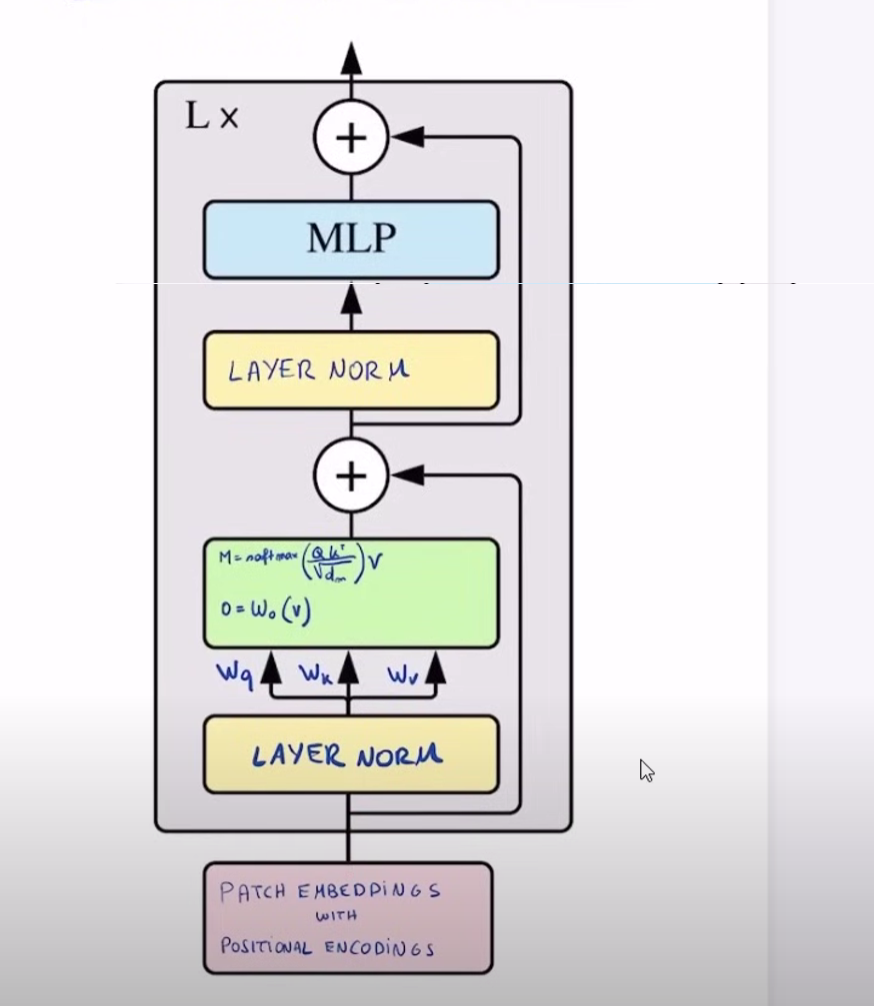

In [ ]:
class SiglipVisionEncoder(nn.Module):
    def __init__(self, config : Siglip_vision_config):
        super().__init__()
        
        self.config = config
        self.self_attention = SiglipSelfAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        
     
     

In [ ]:
class Siglip_vision_transformer(nn.Module):
    def __init__(self, config: Siglip_vision_config): 
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipVisionEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)
    
    
    def forward(self,pixel_values: torch.tensor ) -> torch.tensor:
       
        hidden_states = self.embeddings(pixel_values)# 
        last_hidden_state = self.encoder(hidden_states)  # we use encoder to get the last hidden state
        # Apply layer normalization to the last hidden state
        
        last_hidden_state = self.post_layernorm(input_embeds = last_hidden_state)
        
        return last_hidden_state
        
        
        

In [ ]:
class SigLIPVisionModel(nn.Module):
    def __init__(self, config: Siglip_vision_config):
        super()().__init__()
        self.config = config
        self.vision_model = Siglip_vision_transformer(config)
        

Forward Propagrationn


In [ ]:
def forward(self, pixel_values : torch.FloatTensor) -> torch.Tensor:
     _, _, height, width = pixel_values.shape #Batch size, number of channels, height, width
     
    #we need to convolve the image to get the patches, i.e the "patch_size"
     patch_embeds= self.patch_embeddings(pixel_values)
      # (batch_size, embedding_size, height, width)
    
    # Now, we need to Reshape the patch embeddings to (batch_size, num_patches, embedding_size)
     embeddings = patch_embeds.flatten(2).transpose(1, 2) # (batch_size, num_patches, embedding_size)
     
    #addings positional embeddings
    # The position_ids are the indices of the patches in the flattened tensor, these are learned embeddings
    # The position embeddings are added to the patch embeddings to give each patch a unique position in the sequence
     embeddings = embeddings + self.position_embeddings(self.position_ids)  
     #[batch_size, num_patches, embedding_size]
    # The embeddings are then passed through the encoder, which applies self-attention and feed-forward layers
     
   # return self.vision_model(pixel_values=pixel_values)

NameError: name 'torch' is not defined